In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
df = pd.read_csv("./cleaned_data.csv")
print("Size before removing outliers:", df.shape)

df = df[df["HINCP"] <= 200000]

print("Size after removing outliers:", df.shape)

Size before removing outliers: (36171, 35)
Size after removing outliers: (33536, 35)


In [6]:
y = df["HINCP"]
X = df.drop("HINCP", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
sample_weights = X_train.iloc[:, 0]
X_train = X_train.drop(columns=X_train.columns[0])
X_test = X_test.drop(columns=X_test.columns[0])

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D, Dropout, BatchNormalization

# CNN MODEL

tf.random.set_seed(42)

model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))

# First block
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second block
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third block
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Fourth block
model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Flattening layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1))

In [10]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_dataset,
      epochs=20,
      validation_data=val_dataset,
      callbacks=[early_stopping]
  )
#history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2, verbose=1)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 289457504256.0000 - mae: 42000.8242 - val_loss: 2914273024.0000 - val_mae: 40975.3906
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 132238598144.0000 - mae: 28982.7695 - val_loss: 2608793856.0000 - val_mae: 38446.7031
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 129730494464.0000 - mae: 28854.1270 - val_loss: 2709592832.0000 - val_mae: 39011.6055
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 131174850560.0000 - mae: 28941.7363 - val_loss: 2152792064.0000 - val_mae: 34469.9219
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 128310362112.0000 - mae: 28710.5762 - val_loss: 1321070080.0000 - val_mae: 27770.7695
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 127427141632.0000 - mae: 28710.5332 - val_loss: 1343535616.0000 - val_mae: 27665.8848
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 128079626240.0000 - mae: 28567.1348 - val_loss: 1316213248.000

Test Mean Absolute Error: 27832.228515625
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


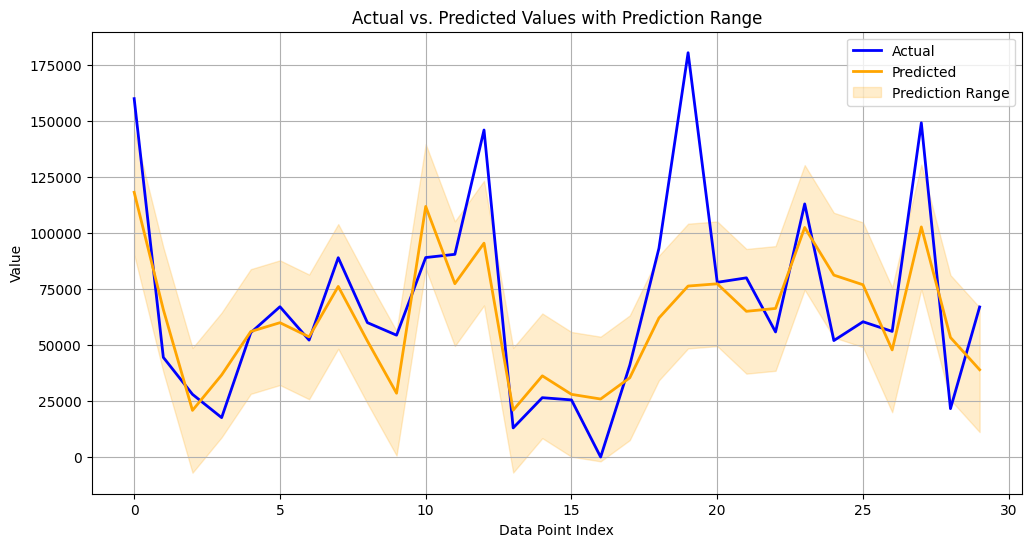

In [23]:
range1 = 30
range2 = 60

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Absolute Error: {mae}")

y_pred = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test.values[range1:range2], 'Predicted': y_pred.flatten()[range1:range2]})

results_df['Upper_Bound'] = results_df['Predicted'] + mae
results_df['Lower_Bound'] = results_df['Predicted'] - mae

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(results_df['Predicted'], label='Predicted', color='orange', linewidth=2)

plt.fill_between(results_df.index,
                 results_df['Lower_Bound'],
                 results_df['Upper_Bound'],
                 color='orange', alpha=0.2, label='Prediction Range')

plt.title("Actual vs. Predicted Values with Prediction Range")
plt.xlabel("Data Point Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


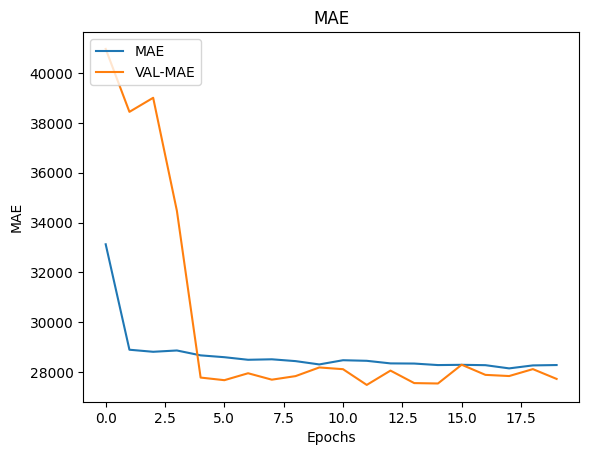

In [14]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['MAE', 'VAL-MAE'], loc='upper left')
plt.show()

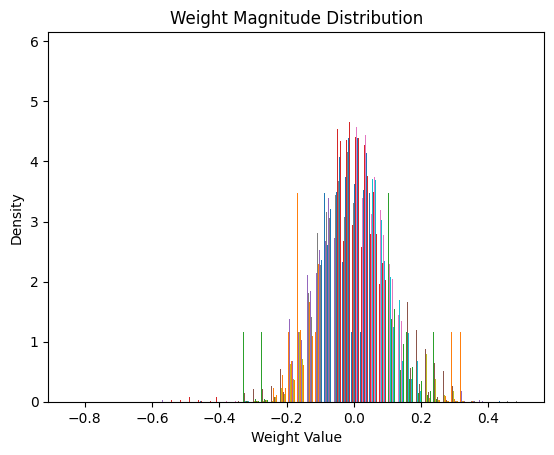

In [15]:
weights = model.get_weights()
flattened_weights = [w.flatten() for layer in weights for w in layer if w.ndim > 1]

plt.hist(flattened_weights, bins=50, density=True)
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.title('Weight Magnitude Distribution')
plt.show()


In [17]:
!pip install ace-tools